# MovingBox Intermediate Frame Prediction by LSTM

In [2]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from util.tf_ops import *
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image
import tensorflow.contrib.rnn as rnn

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Load Train and Test Data

In [3]:
train_collection =  get_collection("data/moving-box/train")

train_collection = center_collections(train_collection)
# total number of images
total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

{'dim': (50, 32, 32), 'images:': 'triangle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'trangle-vertical'}
{'dim': (56, 32, 32), 'images:': 'circle-diagnal'}
{'dim': (56, 32, 32), 'images:': 'bigsquare-vertical-4'}
{'dim': (56, 32, 32), 'images:': 'diamond'}
{'dim': (56, 32, 32), 'images:': 'big-diamond-vertical'}
{'dim': (56, 32, 32), 'images:': 'diamond-vertical3'}
{'dim': (56, 32, 32), 'images:': 'square-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-4'}
{'dim': (56, 32, 32), 'images:': 'big-diamond-diagnal1'}
{'dim': (56, 32, 32), 'images:': 'big-diamond-vertical2'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'big-diamond-vertical3'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-vertical'}
{'dim': (56, 32, 32), 'images:': 'bigSquare-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-5'}
{'dim': (56, 32, 32), 'images:': 'trangle-vertic

In [258]:
test_collection = get_collection("data/moving-box/test")
test_collection = augment_reverse_color(test_collection)
test_collection = center_collections(test_collection)
# total number of images
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

{'images:': 'rectangle', 'dim': (56, 32, 32)}

After Augmentation: Test set has 2 collections, 112 images in total


## Sample

In [259]:
def sample(collection, batch_size = 8, gap = 1, seq_size = 3):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        (train_input, train_gd)
        
        train_input: [batch size, seq_size, 32, 32]
        train_gd:    [batch size, seq_size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !" 
    
    def expand_start_to_seq(start_ind):
        """
        Input:
            start_ind: a number indicating index of start frame
        Output:
            np array of [start_ind, start_ind + gap +1, start_ind + 2*(gap+1) ...]
        """
        return np.array([start_ind + i * (gap + 1) for i in range(seq_size)])
    
    
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # start-index for each class
    start_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - (gap + 1) * seq_size), avg_num_per_class, replace=False)
            start_ind.append(s)
        except: # if not enough in this class
            print("err")
            start_ind.append(np.array([]))
    selected_classes = [i for i in range(n_collection) if start_ind[i].shape[0]>0]
    train_ind = [[expand_start_to_seq(s) for s in ind] for ind in start_ind] # train indexes for each class
    gd_ind = [[(x + (gap+1)//2) for x in ind_by_class] for ind_by_class in train_ind]
    train_input = np.concatenate([np.stack([collection[i][j] for j in train_ind[i]]) for i in selected_classes], axis = 0)
    train_gd =  np.concatenate([np.stack([collection[i][j] for j in gd_ind[i]]) for i in selected_classes], axis = 0)
    
    train_input, train_gd = train_input[:batch_size], train_gd[:batch_size]
    return train_input, train_gd


def sample_train(batch_size = 8, gap = 1, seq_size = 3): return sample(train_collection, batch_size, gap = gap, seq_size = seq_size)

def sample_test(batch_size = 8, gap = 1, seq_size = 3):  return sample(test_collection, batch_size, gap, seq_size = seq_size)


## Sample of Training Data

Range of Image Piece Value: [-1.0, 1.0]
seq_input shape:            (4, 6, 32, 32)
seq_gd    shape:            (4, 6, 32, 32)


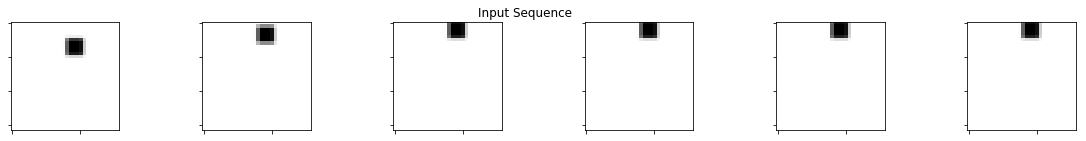

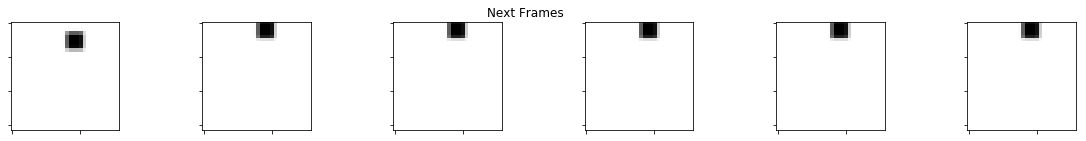

In [393]:
def show_sample_train(batch_size, gap, seq_size):
    seq_input, seq_gd = sample_train(batch_size=batch_size, gap=gap, seq_size= seq_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(seq_input), np.max(seq_input)))
    print("seq_input shape:            {}".format(seq_input.shape))
    print("seq_gd    shape:            {}".format(seq_gd.shape))
    selected = np.random.choice(range(batch_size))
    size = (20, 2)
    plot_images_ndarray(seq_input[selected], title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd[selected], title="Next Frames", size = size)
    
show_sample_train(batch_size = 4, gap = 3, seq_size=6)

### Sample of Test Data

Range of Image Piece Value: [-1.0, 1.0]
seq_input shape:            (2, 5, 32, 32)
seq_gd    shape:            (2, 5, 32, 32)


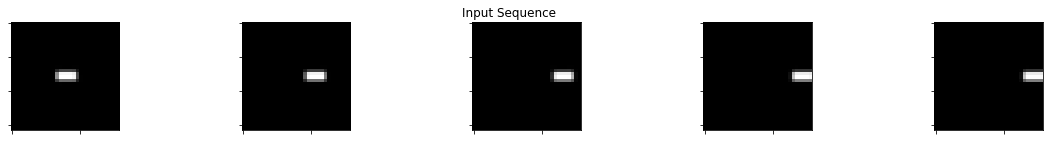

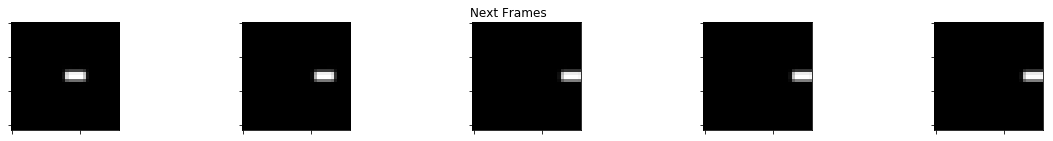

In [287]:
def show_sample_test(batch_size, gap, seq_size):
    seq_input, seq_gd = sample_test(batch_size=batch_size, gap=gap, seq_size= seq_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(seq_input), np.max(seq_input)))
    print("seq_input shape:            {}".format(seq_input.shape))
    print("seq_gd    shape:            {}".format(seq_gd.shape))
    selected = np.random.choice(range(batch_size))
    size = (20, 2)
    plot_images_ndarray(seq_input[selected], title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd[selected], title="Next Frames", size = size)
    
show_sample_test(batch_size = 2, gap = 5, seq_size=5)

# Param

In [371]:
seq_size         = 3
feature_size     = 1024    # size of feature vector for LSTM
lstm_state_size  = feature_size   # size of hidden state: [lstm_state_size, lstm_state_size]

num_iteration    = 1000
gap              = 1
batch_size       = 32
learning_rate    = 1e-3
beta             = 0.9

assert feature_size%64 == 0, "feature_size must be divisable by 64!"
feature_channels = int(feature_size/8/8)

# Encoder

In [374]:
def encode_img(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, feature_size]
    """
    x = img
    x = tf.reshape(img, [-1, 32, 32, 1])
    x = tf.layers.conv2d(x, filters = 16, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channels, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.contrib.layers.flatten(x)
    return x

In [375]:
def encode_seq(img_seq, seq_size = seq_size):
    """
    Input:
        img_seq: sequence of images      Tensor         [batch_size, seq_size, 32, 32]
    Output:
        encoded feature of the sequence  List of Tensor [batch_size, feature_size] of length seq_size
    """
    img_seq = tf.transpose(img_seq, perm=[1, 0, 2, 3]) # [seq_size, batch_size, 32, 32, 1]
    
    return [encode_img(img_seq[i]) for i in range(seq_size)]

# Decoder

In [377]:
def decode(feature, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    x = tf.reshape(feature, [-1, 8, 8, feature_channels])
    x = tf.layers.conv2d(x, filters = 128, kernel_size=5, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3,  strides=2, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Loss

In [378]:
def get_loss(gd_imgs, output_imgs):
    """
    Input:
        gd_imgs, output_imgs: [batch_size, seq_size, 8, 8, 1]
    Output:
        scaler loss
    """
    gd_imgs, output_imgs = tf.contrib.layers.flatten(gd_imgs), tf.contrib.layers.flatten(output_imgs)
    return tf.norm(gd_imgs - output_imgs)

In [379]:
def scale_loss(loss, seq_size = seq_size, batch_size = batch_size):
    return loss/seq_size/batch_size/2*255

### Solver

In [380]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

## Computation Graph

In [381]:
tf.reset_default_graph()
batch_seq        = tf.placeholder(tf.float32, [None, seq_size, 32, 32])
batch_next       = tf.placeholder(tf.float32, [None, seq_size, 32, 32])
is_training      = tf.placeholder(tf.bool, ())


feature_seq      =  encode_seq(batch_seq)
lstm_cell        = rnn.BasicLSTMCell(lstm_state_size)

output_feature, states = rnn.static_rnn(lstm_cell, feature_seq, dtype=tf.float32)
output_imgs = tf.stack([decode(f) for f in output_feature], axis = 1)  # [seq_size, batch_size, 32, 32, 1]

loss = get_loss(batch_next, output_imgs)


solver = get_solver(learning_rate, beta)

train_step = solver.minimize(loss)

In [386]:
def train(sess, train_step, loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, num_plot = 6):
    losses = []
    for i in range(num_iteration):
        # get a sample
        # gap = np.random.choice([1,3,5,7,9])
        seq_input, seq_gd = sample_train(batch_size, gap)
        dic = {batch_seq: seq_input, batch_next: seq_gd, is_training: True}
        
        sess.run([train_step], dic)
        curr_loss = sess.run(loss, dic)
        curr_loss = scale_loss(curr_loss)# tweek loss to match report loss
        
        losses.append(curr_loss)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  loss = {} | Gap = {}".format(i, curr_loss, gap))
            
        if i%plot_every == 0:
            seq_input, seq_gd = sample_train(1, gap)
            seq_generated = sess.run(output_imgs, feed_dict=\
                                      {batch_seq: seq_input, batch_next: seq_gd, is_training: False})
            seq_generated = seq_generated[0]
            plot_batch_images(seq_generated[:num_plot], (16, 2) , "Iteration: {} | gap = {}".format(i + plot_every, gap))
    return losses

# Train

Iteration 0:  loss = 406.24671936035156 | Gap = 1


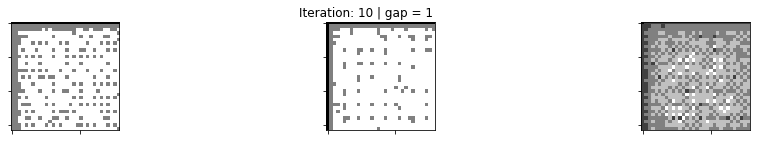

Iteration 10:  loss = 115.31588792800903 | Gap = 1


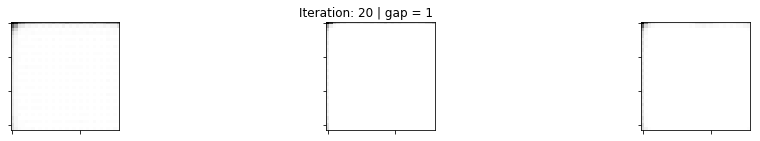

Iteration 20:  loss = 114.48135137557983 | Gap = 1


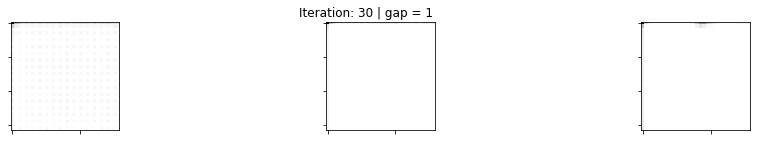

Iteration 30:  loss = 113.10162007808685 | Gap = 1


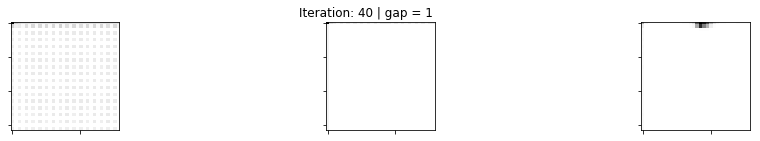

Iteration 40:  loss = 112.72971630096436 | Gap = 1


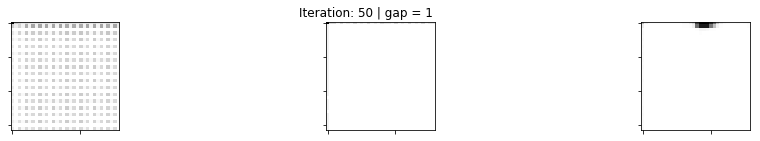

Iteration 50:  loss = 112.17609107494354 | Gap = 1


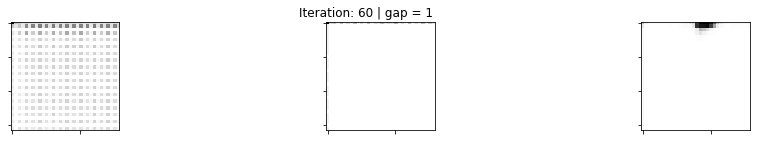

Iteration 60:  loss = 109.29690957069397 | Gap = 1


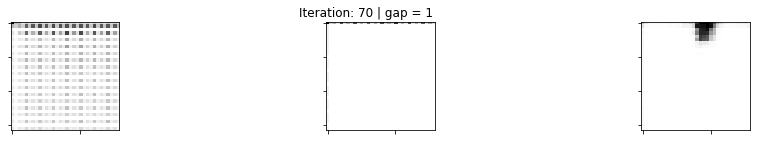

Iteration 70:  loss = 106.50850772857666 | Gap = 1


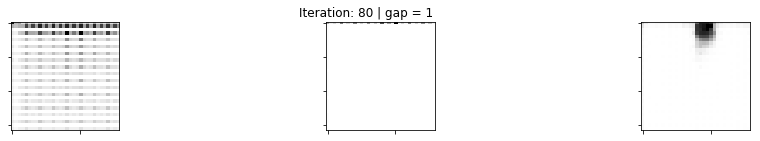

Iteration 80:  loss = 107.82067358493805 | Gap = 1


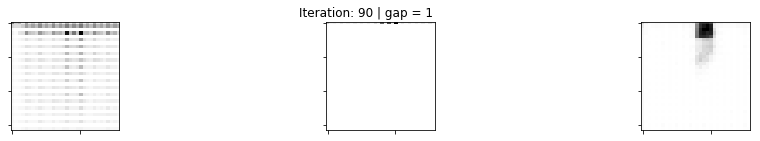

Iteration 90:  loss = 103.91003489494324 | Gap = 1


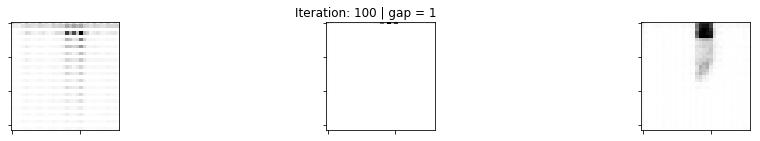

Iteration 100:  loss = 103.99458289146423 | Gap = 1


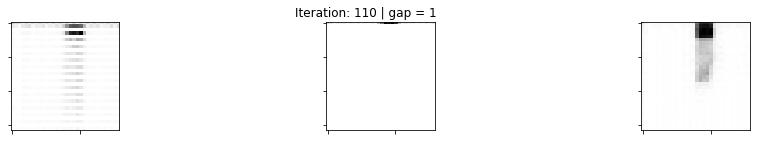

Iteration 110:  loss = 102.08009362220764 | Gap = 1


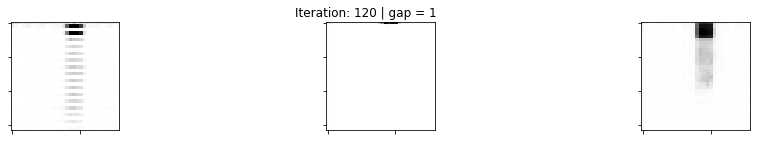

Iteration 120:  loss = 102.93413579463959 | Gap = 1


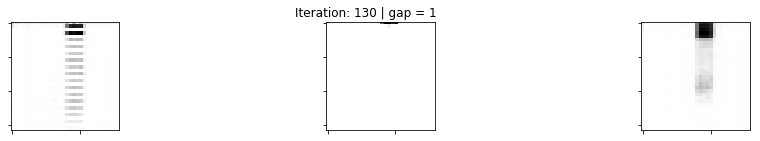

Iteration 130:  loss = 105.48724412918091 | Gap = 1


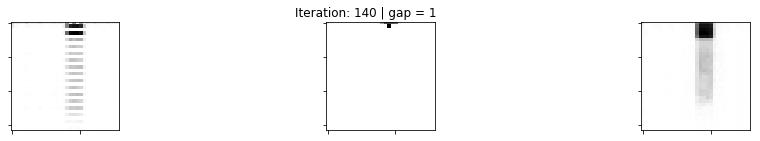

Iteration 140:  loss = 105.74537694454193 | Gap = 1


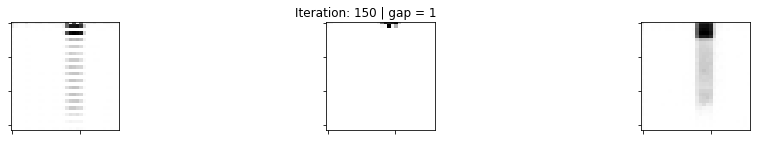

Iteration 150:  loss = 103.37700963020325 | Gap = 1


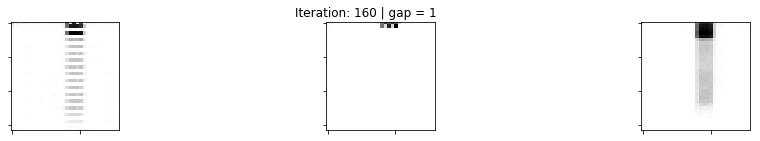

Iteration 160:  loss = 103.39678883552551 | Gap = 1


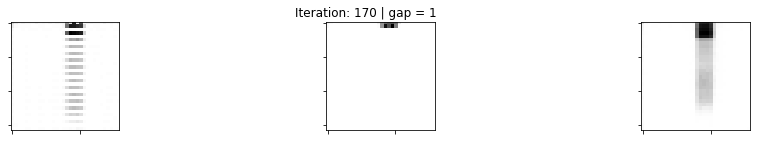

Iteration 170:  loss = 103.42753171920776 | Gap = 1


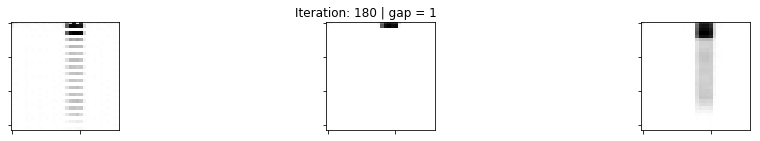

KeyboardInterrupt: 

In [388]:
sess = get_session()
sess.run(tf.global_variables_initializer())
losses = train(sess, train_step, loss, batch_size, num_iteration, plot_every = 10, show_loss_every = 10, num_plot=6)